# Segmentação de objetos

Nesta tarefa, foram exploradas redes profundas para segmentação (classificação pixel a pixel). Foram usadas duas arquiteturas (Xception e MobileNetv2) pré-treinadas no dataset PASCAL, que contém as seguintes classes:
- meios de transporte: avião, bicicleta, carro, motocicleta, ônibus, trem, barco;
- animais: cachorro, gato, pássaro, vaca, cavalo, ovelha;
- itens de casa: mesa de jantar, cadeira, planta em vaso/potted plant (?), televisão, sofá;
- outros: pessoa, garrafa.

formando um conjunto de 20 classes possíveis. Foram feitas inferências usando cenas que contêm estas classes, e também cenas que contêm classes similares fora deste conjunto (felinos selvagens).

Boa parte do código usado aqui foi adaptado do 'live demo' disponível em:
https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

O notebook foi rodado no ambiente do Google Colab sem aceleração de GPU/TPU.

In [0]:
import os
from io import BytesIO
import tarfile
import time
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

### Definição da classe DeepLabModel

Esta classe será usada para baixar os modelos pré-treinados, carregá-los no TensorFlow, e fazer as inferências.

In [0]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 3, width_ratios=[6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  #plt.subplot(grid_spec[1])
  #plt.imshow(seg_image)
  #plt.axis('off')
  #plt.title('segmentation map')

  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.subplot(grid_spec[1])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[2])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Download dos modelos pré-treinados



In [3]:
def load_model(url):
    _DOWNLOAD_URL = url
    _TARBALL_NAME = 'deeplab_model.tar.gz'

    model_dir = tempfile.mkdtemp()
    tf.gfile.MakeDirs(model_dir)

    download_path = os.path.join(model_dir, _TARBALL_NAME)
    print('downloading {}...'.format(url))
    start = time.perf_counter()
    urllib.request.urlretrieve(_DOWNLOAD_URL, download_path)
    dt = time.perf_counter() - start
    print('download completed in {0:2.2f} s. loading model...'.format(dt))

    start = time.perf_counter()
    model = DeepLabModel(download_path)
    dt = time.perf_counter() - start
    print('model loaded in {0:2.2f} s.'.format(dt))
    
    return model
  
xception = load_model('http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz')
mobilenet = load_model('http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz')

downloading http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz...
download completed in 2.60 s. loading model...
model loaded in 6.78 s.
downloading http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz...
download completed in 0.33 s. loading model...
model loaded in 0.44 s.


### Visualização das inferências

Foram escolhidas imagens disponíveis na internet para testar os modelos. A entrada é simplemente a url da imagem. O script lê o conteúdo da url, não sendo necessário acessar o disco local.

In [0]:
images = [
    'https://treeday.planetark.org/images/masters/image-4516-dogslovetrees-main-photo-crop-png.jpeg',
    'https://resources.stuff.co.nz/content/dam/images/1/m/d/u/6/k/image.related.StuffLandscapeSixteenByNine.620x349.1paf7n.png/1523253379822.jpg',
    'http://1.bp.blogspot.com/-tU1npj3Oncg/TXj0e3JvhlI/AAAAAAAAAN4/ErcGZFuFTZM/s1600/bird-of-paradise-puppet-love-picture.jpg',
    'https://assets-natgeotv.fnghub.com/Shows/73280.jpg',
    'https://static.boredpanda.com/blog/wp-content/uploads/2018/03/fb-image-sharing-dashboard_5aaa66f626064__700.jpg',
    'https://img.buzzfeed.com/buzzfeed-static/static/2015-02/19/21/enhanced/webdr04/original-30481-1424398994-8.jpg',
    'https://cache.desktopnexus.com/thumbseg/1277/1277364-bigthumbnail.jpg',
    'https://i.pinimg.com/originals/ab/50/df/ab50dfc826e0b7833d2862b3ef80194c.jpg',
    'https://i.pinimg.com/originals/23/55/1e/23551e786f02918764cb638e2722ae8d.jpg',
]

def run_visualization(model, url):
  """Inferences given DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('cannot retrieve image.')
    return

  start = time.perf_counter()
  resized_im, seg_map = model.run(original_im)
  dt = time.perf_counter() - start
  print('inference took {0:2.2f} s'.format(dt))
  vis_segmentation(resized_im, seg_map)

### Inferência usando Xception

inference took 12.35 s


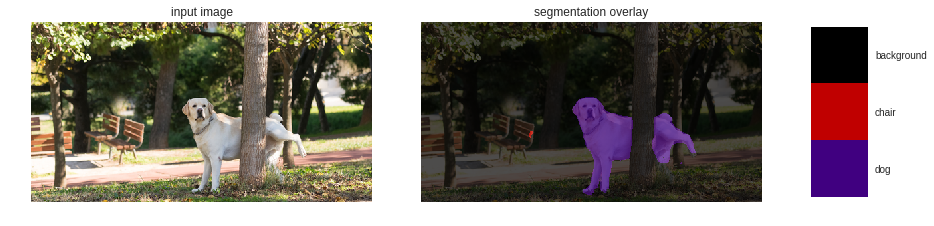

inference took 9.04 s


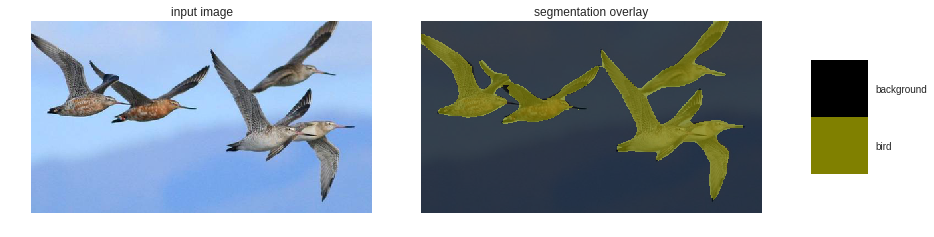

inference took 9.08 s


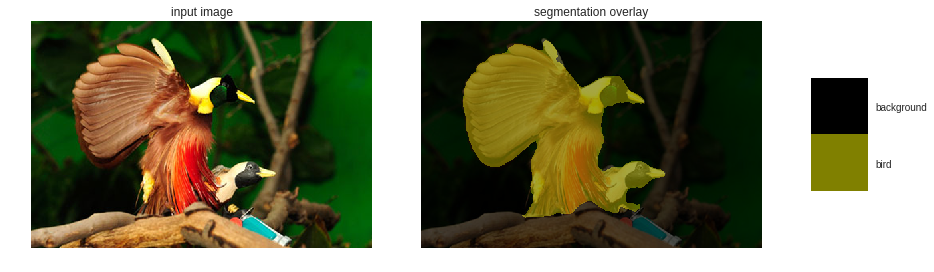

inference took 9.08 s


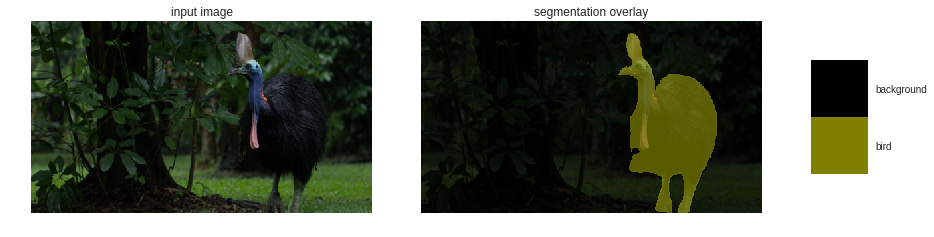

inference took 9.09 s


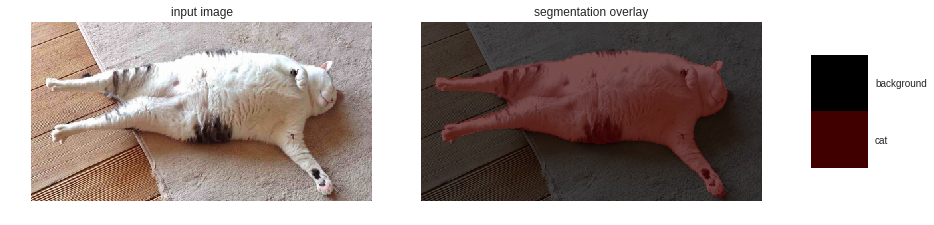

inference took 9.05 s


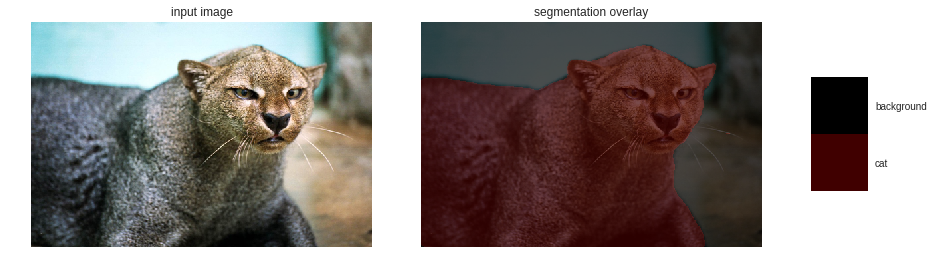

inference took 9.03 s


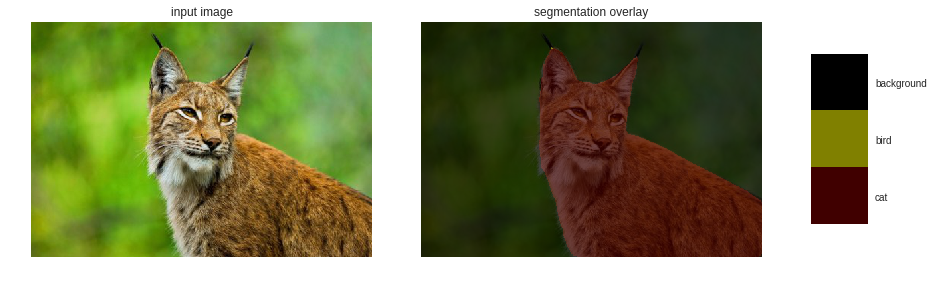

inference took 9.07 s


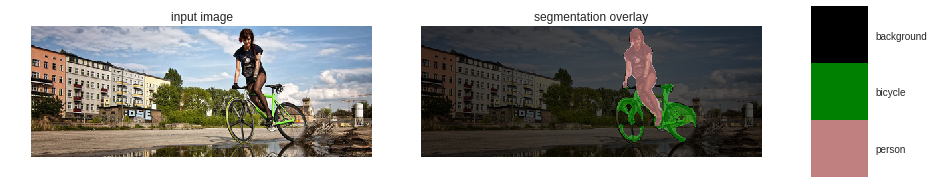

inference took 9.07 s


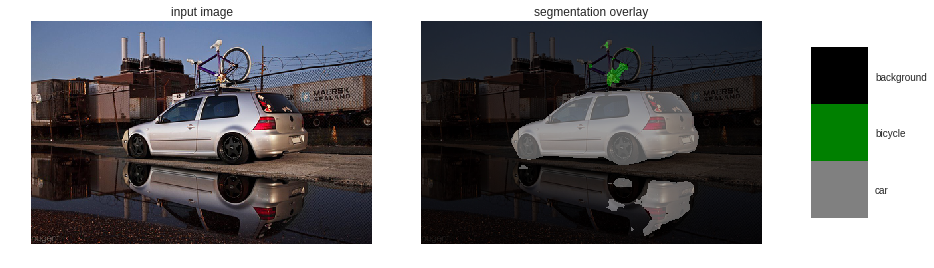

In [5]:
for i in images:
  run_visualization(xception, i)

### Inferência usando MobileNetv2

inference took 1.32 s


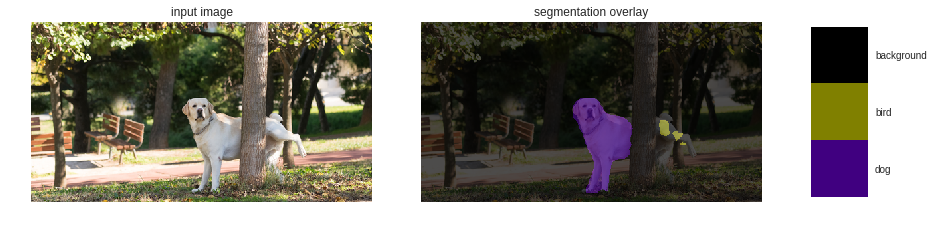

inference took 0.90 s


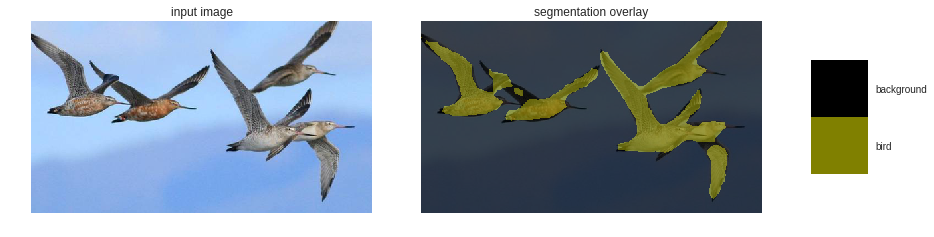

inference took 0.92 s


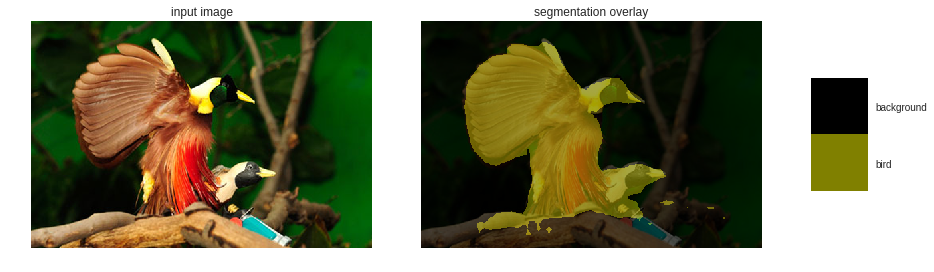

inference took 0.91 s


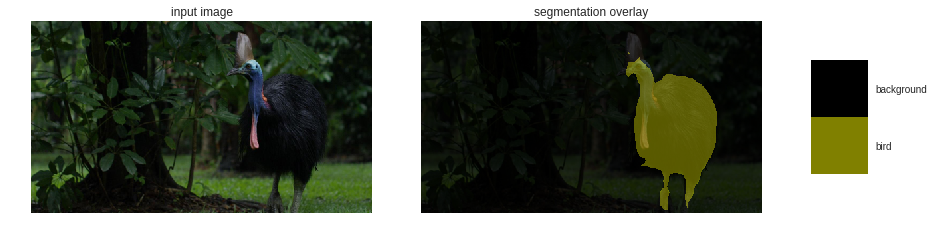

inference took 0.90 s


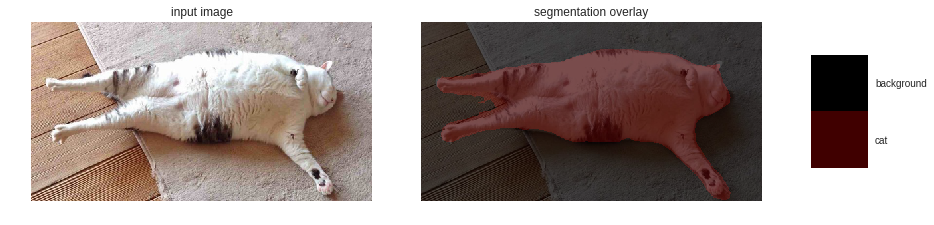

inference took 0.93 s


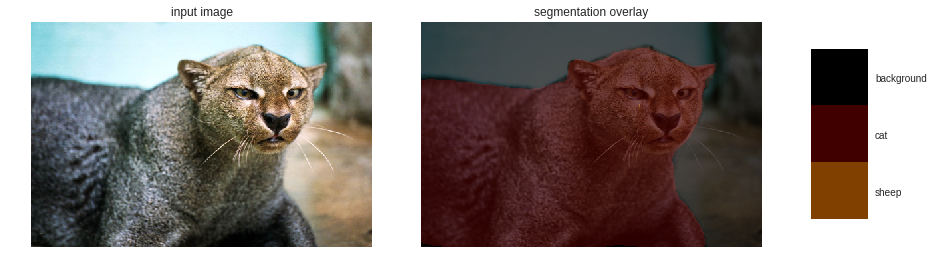

inference took 0.90 s


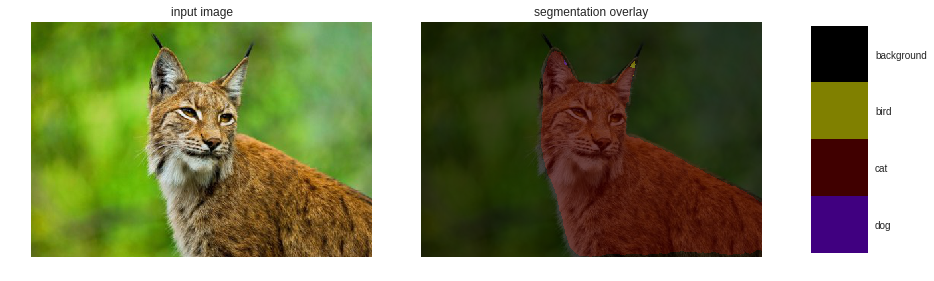

inference took 0.91 s


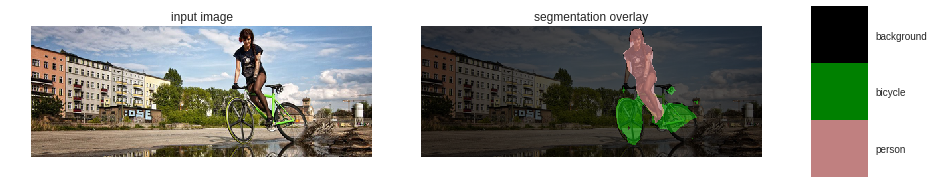

inference took 0.92 s


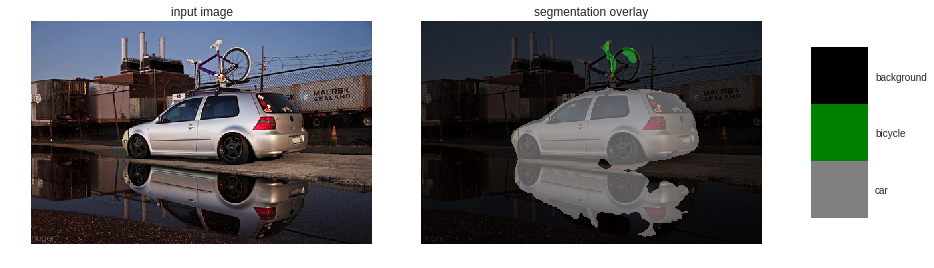

In [6]:
for i in images:
  run_visualization(mobilenet, i)

### Observações

Conforme seria esperado, a arquitetura Xception é mais robusta para delinear o contorno de objetos com oclusão (cachorro atrás da árvore) ou com alta variância intraclasse (pássaros, por serem flexíveis e de espécies muito diferentes). Já a arquitetura MobileNetv2, que foi pensada para dispositivos com poder computacional limitado (celulares e sistemas embarcado), é cerca de 10 vezes mais rápida na inferência.

É interessante notar que, na imagem que contém um carro (que está refletido na poça d'água) e uma bicicleta, a MobileNetv2 capturou uma região maior do carro refletido. Isso representaria erro ou mais flexibilidade (o que seria contraintuitivo, já que a MobileNetv2 tem menos pesos que o Xception)?

Ambas as arquiteturas classificaram os felinos selvagens adequadamente como gato, e classificaram uma pequena região da orelha de um felino como pássaro. A MobileNetv2, entretanto, ficou mais 'confusa': além de classificá-los adequadamente como gato, ela classificou um felino como ovelha e outro felino como cachorro.